In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import admix
import matplotlib.pyplot as plt
import dask
import dask.array as da
import admix_genet_cor
import xarray as xr

In [2]:
a = np.load("out/debug/correct-A1.chr22.npy")[0:100, :]
b = np.load("out/debug/A1.chr22.npy")[0:100, :]
c = np.load("out/admix-grm/hm3.uniform.chr22.A1.npy")[0:100, :]
d = (
    np.load("out/OLD_admix_grm/K1.chr22.npy")[0:100, :]
    + np.load("out/OLD_admix_grm/K2.chr22.npy")[0:100, :]
)

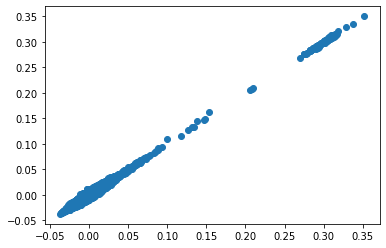

In [6]:
plt.scatter(a.flatten(), c.flatten())

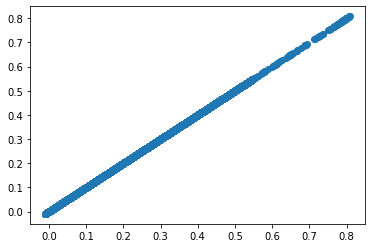

In [7]:
plt.scatter(b.flatten(), d.flatten())

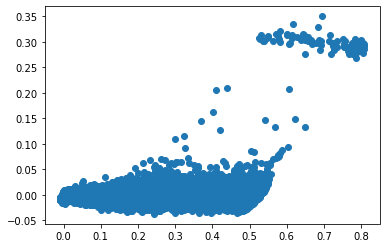

In [8]:
plt.scatter(b.flatten(), c.flatten())

In [2]:
# a = np.load("out/debug/correct-A1.chr22.npy")[0:100, :]
# b = np.load("out/debug/A1.chr22.npy")[0:100, :]
# c = np.load("out/admix-grm/hm3.uniform.chr22.A1.npy")[0:100, :]

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# plt.scatter(a.flatten(), b.flatten())
# fig.show()

# fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
# plt.scatter(a.flatten(), c.flatten())
# ax.plot([-0.1, 0.4], [-0.1, 0.4])
# ax.set_xlim(-0.1, 0.4)
# ax.set_ylim(-0.1, 0.4)
# fig.show()

In [3]:
def af_per_anc(dset: xr.Dataset, inplace=True):
    """
    Calculate allele frequency per ancestry
    Parameters
    ----------
    dset: xr.Dataset
        Containing geno, lanc, n_anc
    Returns
    -------
    List[np.ndarray]
        `n_anc` length list of allele frequencies.
    """
    assert "geno" in dset.data_vars, "`geno` not in `ds.data_vars`"
    assert "lanc" in dset.data_vars, "`lanc` not in `ds.data_vars`"
    n_anc = dset.attrs["n_anc"]
    geno = dset.data_vars["geno"]
    lanc = dset.data_vars["lanc"]
    rls = []
    for i_anc in range(n_anc):
        # mask SNPs with local ancestry not `i_anc`
        rls.append(
            da.ma.getdata(
                da.ma.masked_where(lanc != i_anc, geno).mean(axis=(0, 2))
            ).compute()
        )
    rls = da.from_array(np.array(rls)).T
    if inplace:
        dset["af_per_anc"] = xr.DataArray(
            rls,
            dims=(
                "snp",
                "anc",
            ),
        )
        return None
    else:
        return rls


def allele_per_anc(ds, center=False, inplace=True):
    """Get allele count per ancestry
    Parameters
    ----------
    ds: xr.Dataset
        Containing geno, lanc, n_anc
    center: bool
        whether to center the data around empirical frequencies of each ancestry
    inplace: bool
        whether to return a new dataset or modify the input dataset
    Returns
    -------
    Return allele counts per ancestries
    """
    geno, lanc = ds.data_vars["geno"].data, ds.data_vars["lanc"].data

    n_anc = ds.attrs["n_anc"]
    assert np.all(geno.shape == lanc.shape), "shape of `hap` and `lanc` are not equal"
    assert geno.ndim == 3, "`hap` and `lanc` should have three dimension"
    n_indiv, n_snp, n_haplo = geno.shape
    assert n_haplo == 2, "`n_haplo` should equal to 2, check your data"

    assert isinstance(geno, da.Array) & isinstance(
        lanc, da.Array
    ), "`geno` and `lanc` should be dask array"

    # make sure the chunk size along the ploidy axis to be 2
    geno = geno.rechunk({2: 2})
    lanc = lanc.rechunk({2: 2})

    assert (
        geno.chunks == lanc.chunks
    ), "`geno` and `lanc` should have the same chunk size"

    def helper(geno_chunk, lanc_chunk, n_anc, af_chunk=None):

        n_indiv, n_snp, n_haplo = geno_chunk.shape
        apa = np.zeros((n_indiv, n_snp, n_anc), dtype=np.float64)

        for i_haplo in range(n_haplo):
            haplo_hap = geno_chunk[:, :, i_haplo]
            haplo_lanc = lanc_chunk[:, :, i_haplo]
            for i_anc in range(n_anc):
                if af_chunk is None:
                    apa[:, :, i_anc][haplo_lanc == i_anc] += haplo_hap[
                        haplo_lanc == i_anc
                    ]
                else:
                    apa[:, :, i_anc][haplo_lanc == i_anc] += haplo_hap[
                        haplo_lanc == i_anc
                    ] - af_chunk[:, np.where(haplo_lanc == i_anc)[1], i_anc].squeeze(
                        axis=0
                    )
        return apa

    if center:
        if inplace:
            af_per_anc(ds, inplace=True)
            af = ds.data_vars["af_per_anc"].data
        else:
            af = af_per_anc(ds, inplace=False)
        # rechunk so that all chunk of `n_anc` is passed into the helper function
        assert (
            n_anc == 2
        ), "`n_anc` should be 2, NOTE: not so clear what happens when `n_anc = 3`"
        af = af.rechunk({0: geno.chunks[1], 1: n_anc})

        rls_allele_per_anc = da.map_blocks(
            lambda geno_chunk, lanc_chunk, af_chunk: helper(
                geno_chunk=geno_chunk,
                lanc_chunk=lanc_chunk,
                n_anc=n_anc,
                af_chunk=af_chunk,
            ),
            geno,
            lanc,
            af[None, :, :],
            dtype=np.float64,
        )

    else:
        rls_allele_per_anc = da.map_blocks(
            lambda geno_chunk, lanc_chunk: helper(
                geno_chunk=geno_chunk, lanc_chunk=lanc_chunk, n_anc=n_anc
            ),
            geno,
            lanc,
            dtype=np.float64,
        )
    if inplace:
        ds["allele_per_anc"] = xr.DataArray(
            rls_allele_per_anc, dims=("indiv", "snp", "anc")
        )
    else:
        return rls_allele_per_anc

In [4]:
def admix_grm(dset, center: bool = False, inplace=True):
    """Calculate ancestry specific GRM matrix
    Parameters
    ----------
    center: bool
        whether to center the `allele_per_ancestry` matrix
        in the calculation
    inplace: bool
        whether to return a new dataset or modify the input dataset
    Returns
    -------
    If `inplace` is False, return a dictionary of GRM matrices
        - K1: np.ndarray
            ancestry specific GRM matrix for the 1st ancestry
        - K2: np.ndarray
            ancestry specific GRM matrix for the 2nd ancestry
        - K12: np.ndarray
            ancestry specific GRM matrix for cross term of the 1st and 2nd ancestry
    If `inplace` is True, return None
        "admix_grm_K1", "admix_grm_K2", "admix_grm_K12" will be added to the dataset
    """

    geno = dset["geno"].data
    lanc = dset["lanc"].data
    n_anc = dset.attrs["n_anc"]
    assert n_anc == 2, "only two-way admixture is implemented"
    assert np.all(geno.shape == lanc.shape)
    # TODO: everytime should we recompute? or use the cached version?
    # how to make sure the cache is up to date?
    apa = allele_per_anc(dset, center=center, inplace=False).astype(float)

    n_indiv, n_snp = apa.shape[0:2]

    a1, a2 = apa[:, :, 0], apa[:, :, 1]

    K1 = np.dot(a1, a1.T) / n_snp
    K2 = np.dot(a2, a2.T) / n_snp
    K12 = np.dot(a1, a2.T) / n_snp

    if inplace:
        dset["admix_grm_K1"] = xr.DataArray(K1, dims=("indiv", "indiv"))
        dset["admix_grm_K2"] = xr.DataArray(K2, dims=("indiv", "indiv"))
        dset["admix_grm_K12"] = xr.DataArray(K12, dims=("indiv", "indiv"))
        return None
    else:
        return {"K1": K1, "K2": K2, "K12": K12}

In [5]:
def submit_grm(chrom):
    from dask.distributed import Client, progress

    client = Client(
        processes=False, threads_per_worker=1, n_workers=1, memory_limit="32GB"
    )

    dset = admix_genet_cor.load_page_hm3(chrom=chrom)
    admix_grm(dset, center=True)
    dset["A1"] = (
        ("indiv", "indiv"),
        dset["admix_grm_K1"].data + dset["admix_grm_K2"].data,
    )
    dset["A2"] = (
        ("indiv", "indiv"),
        dset["admix_grm_K12"].data + dset["admix_grm_K12"].data.T,
    )

    A1, A2 = dask.compute(dset["A1"], dset["A2"])

    np.save(f"out/debug/correct-A1.chr{chrom}.npy", A1)
    np.save(f"out/debug/correct-A2.chr{chrom}.npy", A2)

In [6]:
import submitit

executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=240,
    memory_g=36,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_grm, np.arange(1, 23).tolist())